In [1]:
%load_ext autoreload
%autoreload 2

import markovlink
import numpy as np
import numpy.random as npr
import scipy as sp
import pickle
import matplotlib.pylab as plt
import sys
from IPython.lib import backgroundjobs
jobs = backgroundjobs.BackgroundJobManager()

%matplotlib inline

# the input

In [2]:
# example input: two matrices, Nly and Nlx
with open('exampletables.pkl','rb') as f:
    locals().update(pickle.load(f))

Our original data comes in the form of two tables.

The first table, `Nlx`, gives the result of running technique I one some data.  This technique takes in a given specimen and returns one of a finite number of different responses, each of which tells us something different about the specimen.  In this case, these responses corresponded to guesses about the cell type of the specimens, which were cells.  In general, any measurement tool that gives one of a discrete number of responses can be used (or, if the response is continuous, we can bin responses to make them discrete).  

To be concrete: `Nlx[l,x]` gives the  the number of samples from subpopulation `l` that that measured as `x` by technique I.  We expect `Nlx` to be a numpy matrix.  

Our input data also has 
- `cre_names`, which gives the name of each subpopulation
- `facs_names`, which gives the name of each possible `x` measurement
- `patch_names`, which gives the name of each possible `y` measurement

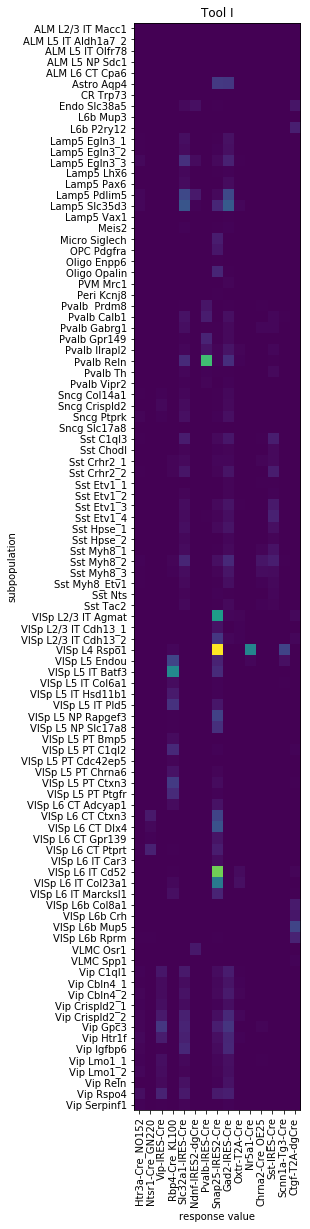

In [3]:
plt.imshow(Nlx.T); plt.ylabel('subpopulation'); plt.xlabel("response value");
plt.title("Tool I")
plt.gcf().set_size_inches(10,20)
plt.xticks(range(len(cre_names)),cre_names,rotation='vertical')
plt.yticks(range(len(facs_names)),facs_names)
plt.savefig("images/Nlx.png",dpi=300,bbox_inches='tight')

The second table, `Nly`, is based on a completely different dataset, run on completely different specimens, with completely different technique.  These specimens were treated with technique II, which also returns one of a finite number of different responses.   `Nly[l,y]` gives the number of samples from subpopulation `l` that were measured as `y` by technique II.

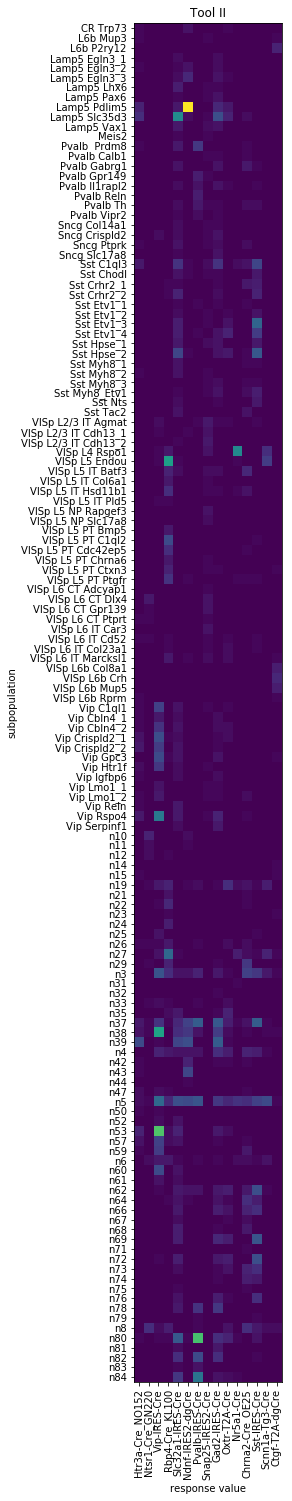

In [124]:
plt.imshow(Nly.T); 
plt.ylabel('subpopulation'); plt.xlabel("response value"); 
plt.title("Tool II")
plt.gcf().set_size_inches(10,25)
plt.xticks(range(len(cre_names)),cre_names,rotation='vertical')
plt.yticks(range(len(patch_names)),patch_names)
plt.savefig("images/Nly.png",dpi=300,bbox_inches='tight')

In no case was the *same specimen* observed using both techniques.  However, both techniques sampled from the same set of subpopulations.  Using a Markov Link assumption, this enables us to determine a set of possible calibrations, or correspondences between the two methods.

# The Markov Link Method

The first step is to estimate the distribution of $p(x|\ell)$, using our tables.  We do this by simply taking the empirical distribution with a simple psuedocount.  Just for point of reference, let's also look at the distribution of $p(y|\ell)$.

Text(0.5,0,'cell type')

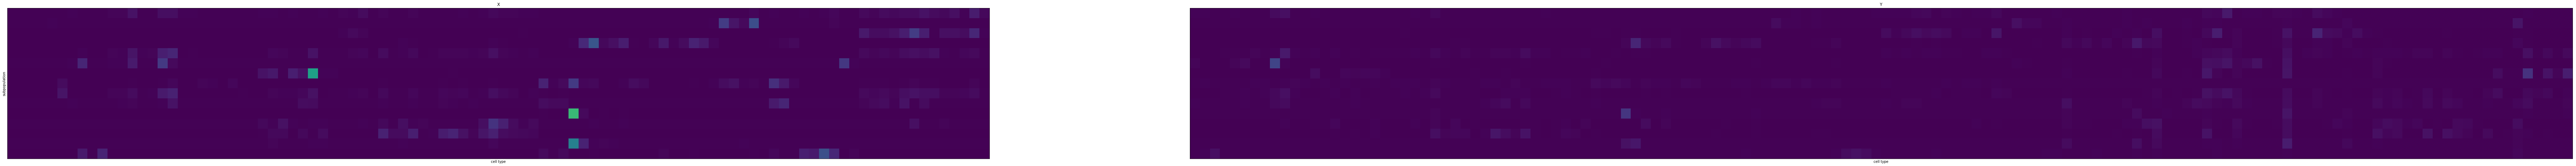

In [8]:
plx = (Nlx+1) / np.sum(Nlx+1,axis=1,keepdims=True) # we use psuedocounts
ply = (Nly+1) / np.sum(Nly+1,axis=1,keepdims=True) # we use psuedocounts

plt.gcf().set_size_inches(40,10)

ax=plt.gcf().add_axes([0,0,plx.shape[1]/100.0,1])
plt.imshow(plx,vmin=0,vmax=1); plt.title("X"); plt.xticks([]); plt.yticks([]);
plt.ylabel("subpopulation")
plt.xlabel("cell type")

ax=plt.gcf().add_axes([plx.shape[1]/100.0+.2,0,ply.shape[1]/100.0,1])
plt.imshow(ply,vmin=0,vmax=1); plt.title("Y"); plt.xticks([]); plt.yticks([]);
plt.xlabel("cell type")

Using this and the Nly data, the markov link method gives us a way to estimate $q(y|x)$.

In [9]:
KAPPA=.01
qhat = markovlink.train_q(plx,Nly,kappa=KAPPA)

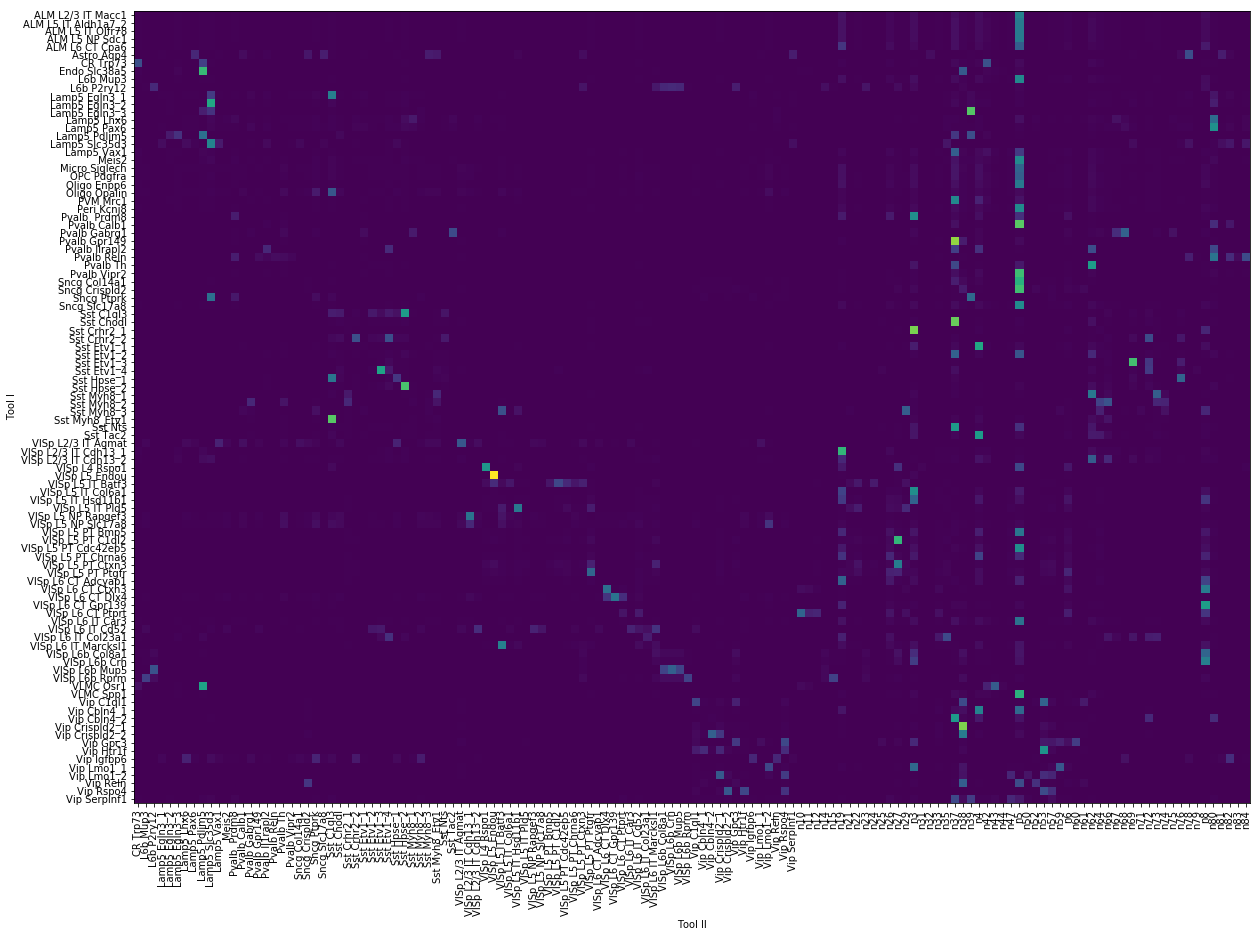

In [127]:
plt.imshow(qhat)
plt.gcf().set_size_inches(20,20)
plt.ylabel('Tool I')
plt.xlabel("Tool II")
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical')
plt.yticks(range(len(facs_names)),facs_names)
plt.savefig("images/qhat.png",dpi=300,bbox_inches='tight')

# Model criticism

We have assumed that our data can be modeled as $p(X|\ell)q(Y|X)$.  Due to the limitations of our data, it is not possible to ever be sure whether this assumption is really correct.  However, there are some limited checks we can perform, and would be be remiss if we ignored them.

One basic test would be to make sure that our model performs well on aspects of the data we *can* test.  In particular, our trained model implies a very specific distriution for $\mathbb{P}(Y=y|\ell)$, namely $h(y|\ell)\triangleq \sum_x \hat p(X|\ell)\hat q(y|x)$.  On the other hands, there are other more conventional ways of estimating the distribution of $\mathbb{P}(Y=y|\ell)$ from the data we have -- namely by using an empirical distribution.  We can compare these two methods for estimating $\mathbb{P}(Y=y|\ell)$ in terms of how well they model held-out data.

First we split data into training data and testing data:

In [9]:
print("We have",np.sum(Nly),"total samples")
holdout=25
Nly_train,Nly_test = markovlink.train_test_split(Nly,holdout)
print("Now we have",np.sum(Nly_train),"samples to train p(y|l) and",np.sum(Nly_test),"samples to test on")

We have 2281.0 total samples
Now we have 1906.0 samples to train p(y|l) and 375.0 samples to test on


Train the model on just the training data

In [10]:
# a version of qhat trained only on just the training data
qhat_train = markovlink.train_q(plx,Nly_train,kappa=KAPPA)

# this yields an estimate for the distribution P(y|l)
h_train = plx @ qhat_train

Train a more traditional traditional estimate for $p(y|\ell)$

In [11]:
h_train2=Nly_train.copy()
h_train2=h_train2+1.0 # pseudocount of 1.0
h_train2=h_train2/np.sum(h_train2,axis=1,keepdims=True)

We can then compare the two methods.  Fewer nats is better, as it indicates that our model provides a more concise representation of the new observations.  

In [12]:
lik=np.sum(np.log(h_train2)*(Nly_test)) / np.sum(Nly_test)
print("Cost of coding with traditional estimate: %.2f nats per entry"%(-lik))

Cost of coding with traditional estimate: 3.96 nats per entry


In [13]:
lik=np.sum(np.log(h_train)*(Nly_test)) / np.sum(Nly_test)
print("Cost of coding with MLM estimate: %.2f nats per entry"%(-lik))

Cost of coding with MLM estimate: 3.70 nats per entry


This is encouraging.  Our model is as good at predicting held-out data as a more traditional estimate which makes no assumptions on the structure of the data.  In fact, the MLM estimate able to outperform the traditional estimate, perhaps because it somewhat leverage our data about $X$ to help us learn about the distributions on $Y$.

# Measuring our uncertainty about $\hat q$

No estimator is perfect.  We know there will always be some error in any estimate, and the MLM estimate for $\hat q$ is no exception.  In fact, the MLM estimator is subject to error both due to insufficient data and to identifiability issues.  To give us a sense for both of these issues, the MLM has a specific recommendation.  
 
Let a **Bootstrap Rotationally Uniform eXtremal Paired sample (BRUXP)** be defined by the following process.  Select a random direction in $q$-space, i.e. a matrix $d$ with the same shape as $q$ filled with standard normal samples.  Use bootstrap to produce a surrogate dataset.  Train the MLM estimator to obtain $\hat h = \hat p \hat q$.  Define $\hat \Theta_1$ as the set of valid probability matrices $q$ such that $\hat p q = \hat h$.  Find the most extremal vertex in $\hat q_1\in \hat \Theta_1$ in the direction $d$.  Note that finding this extremal vertex requires solves two linear programming problem.   Now repeat the bootstrap to find another surrogate dataset and another estimate $\hat \Theta_2$, then find the most extremal vertex $\hat q_2 \in \hat \Theta_2$ in the direction $-d$.  Store $d,\hat q_1,\hat q_2$.

We can obtain many BRUXP samples.  Within each sample, the pair $\hat q_1,\hat q_2$ gives for the range of what $q$ might be along the direction $d$.  Given the data we have, together with the identifiability issues, we cannot really distinguish where we stand within all these vertices.  The variability amongst these samples indicates our uncertainty about the true $\hat q$.

In [6]:
# b_samples=[]
# for i in range(50):
#     print(i)
#     b_samples.append(markovlink.sample_bootstrap_rux(Nlx,Nly,kappa=KAPPA,use_cvxopt=True))

# nb_samples=[]
# for i in range(50):
#     print(i)
#     nb_samples.append(markovlink.sample_bootstrap_rux(Nlx,Nly,kappa=KAPPA,use_cvxopt=True,bootstrap=False))
    
# with open('examplesamples.pkl','wb') as f:
#     pickle.dump(dict(b_samples=b_samples,nb_samples=nb_samples))


# load it now to look at it
with open('examplesamples.pkl','rb') as f:
    locals().update(pickle.load(f))

One somewhat quantitative way to measure the variability of these samples is to look at the distances between the paired samples.  In particular, below we plot a histogram of $|\hat q_1- \hat q_2|$ among all the BRUXP samples.  These distances indicate the extent of our uncertainty along any given direction $d$.  We can compare this with the extent of the uncertainty we had before we applied our method, i.e. the diameter of the set of probability matrices with these dimensions. 

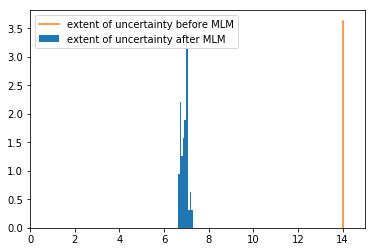

In [10]:
plt.hist([np.sqrt(np.sum((q1-q2)**2)) for (d,q1,q2) in b_samples],density=True,label='extent of uncertainty after MLM');

unconstrained_dist=np.sqrt(2*qhat.shape[0])
plt.plot([unconstrained_dist,unconstrained_dist],[0,plt.ylim()[1]],label='extent of uncertainty before MLM')
plt.xlim(0,unconstrained_dist+1)
plt.legend()
plt.savefig("images/ruxquant.png",dpi=300,bbox_inches='tight')

We can also look at the same thing with RUXP samples

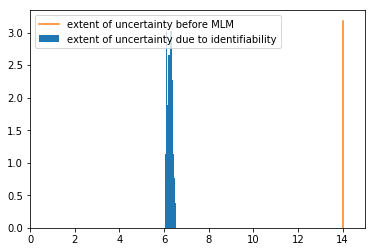

In [11]:
plt.hist([np.sqrt(np.sum((q1-q2)**2)) for (d,q1,q2) in nb_samples],density=True,label='extent of uncertainty due to identifiability');

unconstrained_dist=np.sqrt(2*qhat.shape[0])
plt.plot([unconstrained_dist,unconstrained_dist],[0,plt.ylim()[1]],label='extent of uncertainty before MLM')
plt.xlim(0,unconstrained_dist+1)
plt.legend()
plt.savefig("images/ruxquant2.png",dpi=300,bbox_inches='tight')

More qualitatively, we can look at these samples:

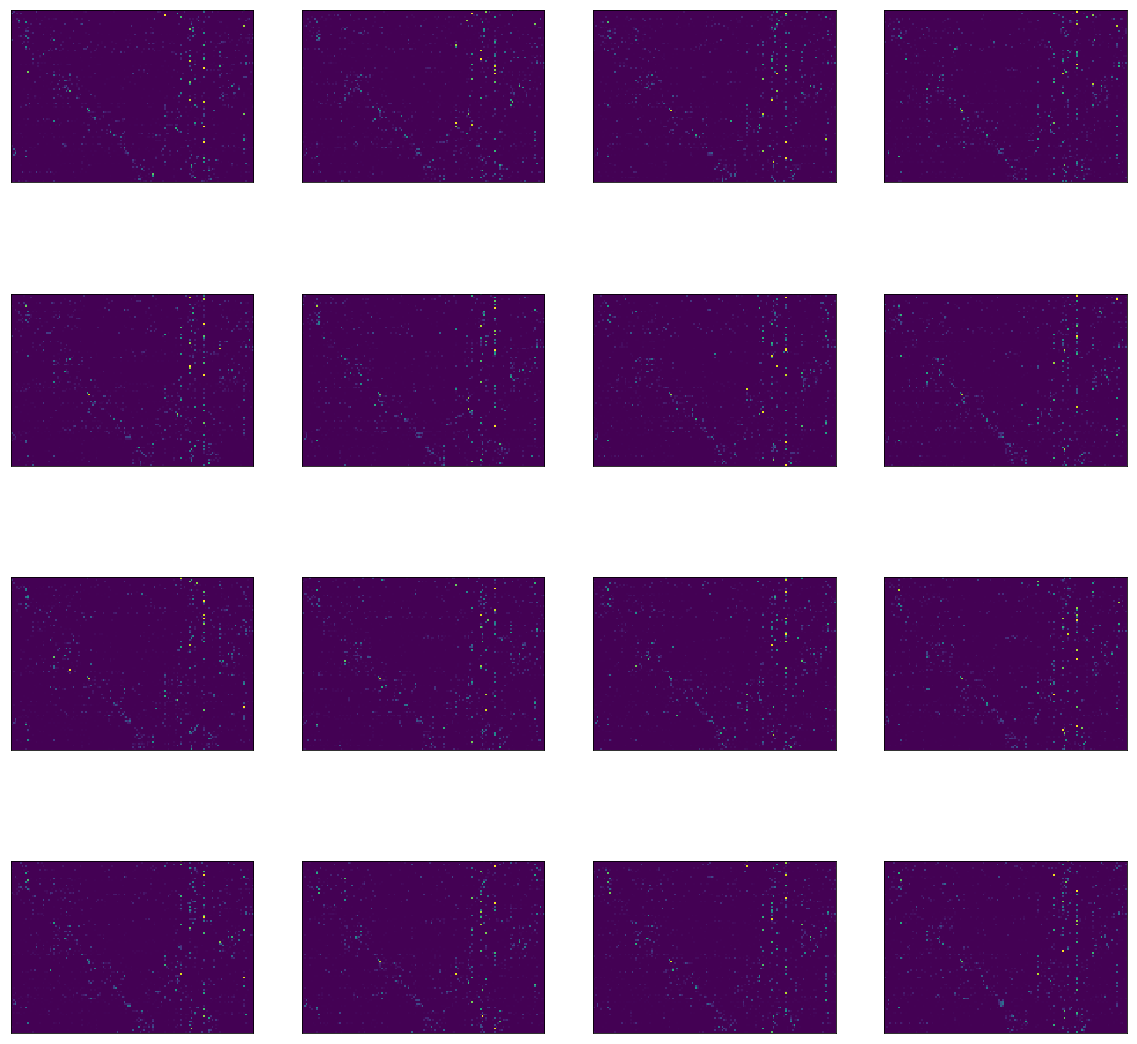

In [13]:
plt.gcf().set_size_inches(20,20)
for i in range(8):
    plt.subplot(4,4,i*2+1)
    plt.imshow(b_samples[i][1],vmin=0,vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(4,4,i*2+2)
    plt.imshow(b_samples[i][2],vmin=0,vmax=1); plt.xticks([]); plt.yticks([])

Note that the samples have a lot in common.  If an aspect of the samples is in common among all the samples, then we have cause to believe that that aspect is present in the true correspondence. 

Let's dig into this issue by looking at only a single row.  We can then make a heatmap where each row indicates a different one of the samples:

Examining the case X='Vip Rspo4'


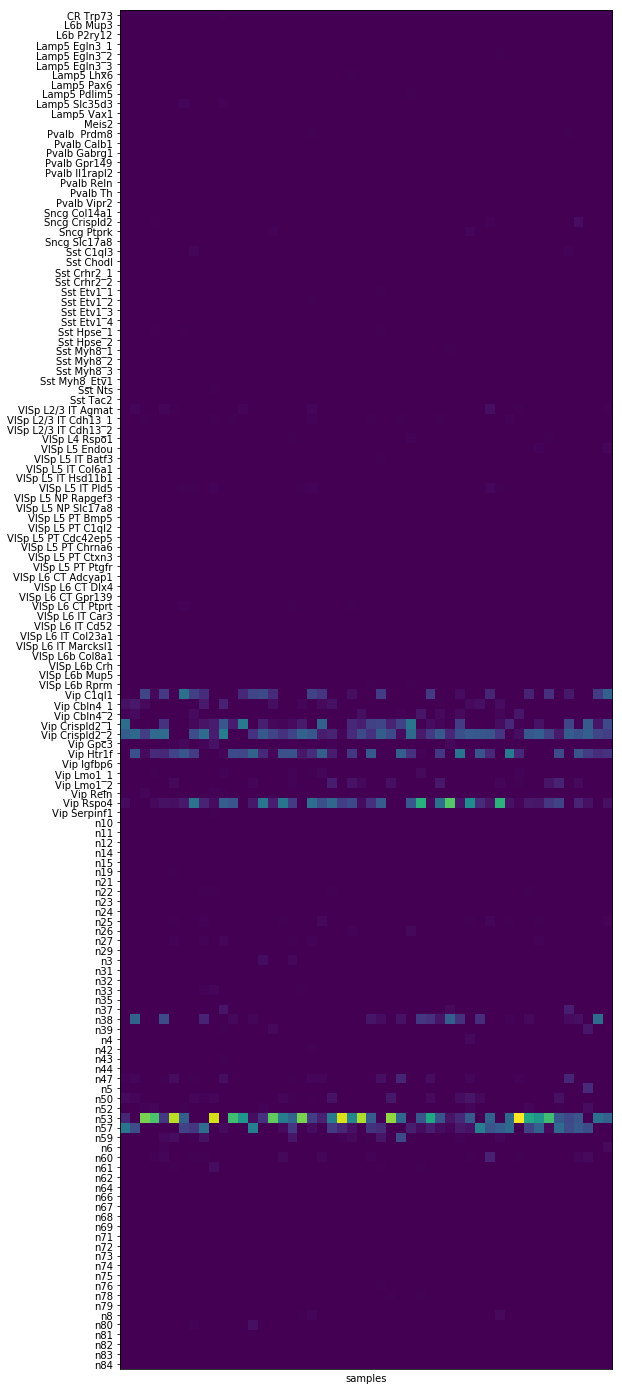

In [14]:
idx=96
plt.gcf().set_size_inches(15,25)
print("Examining the case X='%s'"%facs_names[idx])
subset=np.array([q1[idx] for (d,q1,q2) in b_samples])
plt.imshow(subset.T)
plt.xticks([]);plt.xlabel("samples")
plt.yticks(range(len(patch_names)),patch_names);
plt.savefig("images/VipRspo4.png",bbox_inches='tight',dpi=300)

Here we see that cells designated as type `Vip Rspo4` by method I would generally be asociated with a `Vip` celltype in method II or an `n53` or `n57` type (both of which indicate a group of possible cell types, of which `Vip Rspo4` is one).  However, it is not clear if it is always mapped to `Vip Rspo4`.  For example, it may be that method II would identify these cell as `Vip Htr1f` cells.  This is potentiall concerning.  On the other hand, the plot above suggests that these cells are *not* ever identified as `Vip Lmol_1` cells.  To further resolve this ambiguity, we would need to perform additional experiments involving a subpopulation that might be likely to include `Vip Rspo4` cells but no `Vip Htr1f` cells.

Let's look at another example:

Examining the case X='VISp L5 Endou'


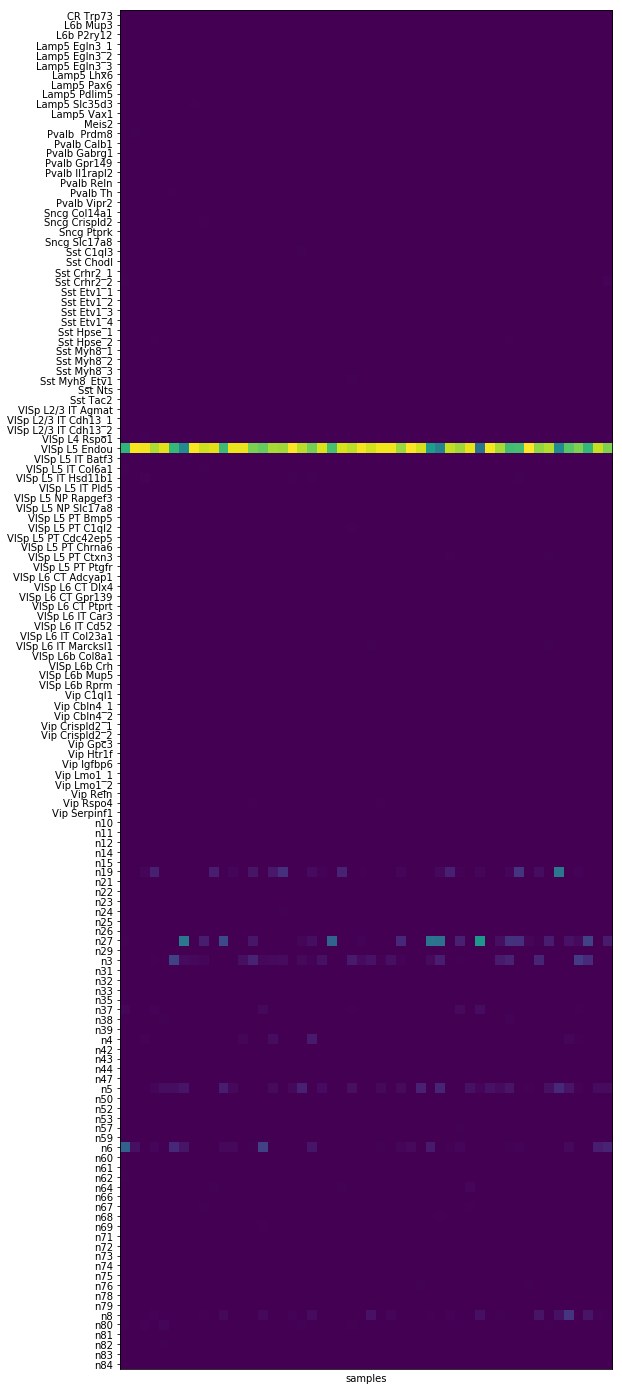

In [15]:
idx=57
plt.gcf().set_size_inches(15,25)
print("Examining the case X='%s'"%facs_names[idx])
subset=np.array([q1[idx] for (d,q1,q2) in b_samples])
plt.imshow(subset.T)
plt.xticks([]);plt.xlabel("samples")
plt.yticks(range(len(patch_names)),patch_names);
plt.savefig("images/Endou.png",bbox_inches='tight',dpi=300)

We can also find the direction of "best possible calibration" and try to the calibration that is consistent with our data and yet as promising as possible in terms of what we wanted the calibration to do.

In [165]:
# the optimal direction maps a type from method I to the same type in method II, 1-1:
d=np.zeros(qhat.shape)
for i,nm in enumerate(facs_names):
    if nm in list(patch_names):
        d[i,list(patch_names).index(nm)]=1
        
# find the q consistent with our estimates of p and h=pq that is most promising in that direction
bestq=markovlink.exploration.find_extremal(plx,qhat,-d,use_cvxopt=True)

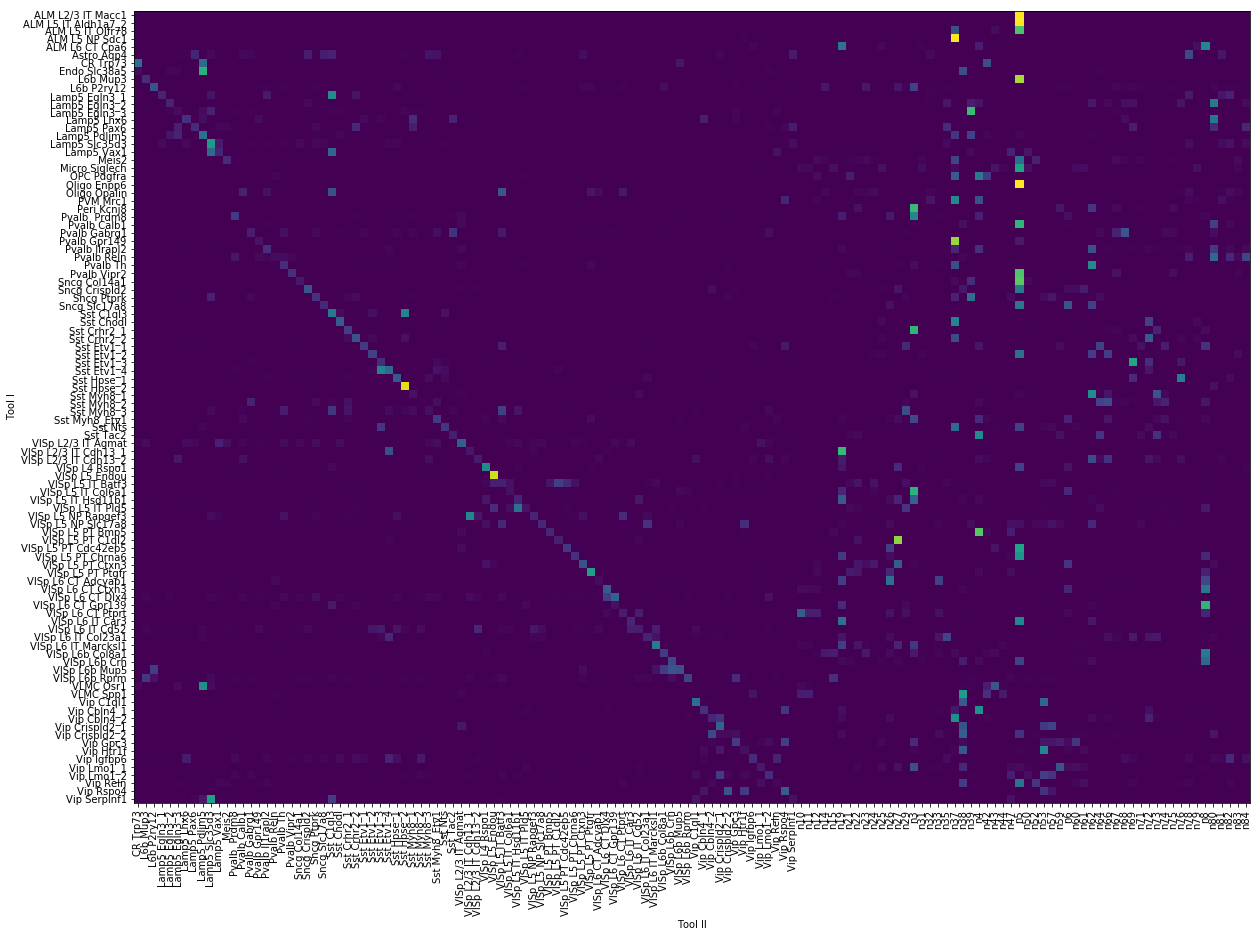

In [167]:
plt.imshow(bestq)
plt.gcf().set_size_inches(20,20)
plt.ylabel('Tool I')
plt.xlabel("Tool II")
plt.xticks(range(len(patch_names)),patch_names,rotation='vertical')
plt.yticks(range(len(facs_names)),facs_names)
plt.savefig("images/bestq.png",dpi=300,bbox_inches='tight')